In [1]:
import numpy as np

import time

import os

from random import randint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

from torch.utils.data import DataLoader

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision import datasets

from models.model import Autoencoder
from utils.data import LimitDataset
from utils.utils import compare

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = './dataset/'

A_path = path+'jaime'
B_path = path+'willyrex'

bs = 16
num_workers=2

In [3]:
data_transforms = transforms.Compose([
        transforms.Resize(224),#RandomResizedCrop(224)??
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

A_dataset = datasets.ImageFolder(os.path.join(A_path), data_transforms)
B_dataset = datasets.ImageFolder(os.path.join(B_path), data_transforms)

number_of_images = compare(len(A_dataset), len(B_dataset), 'smaller')

A_dataset = LimitDataset(A_dataset, number_of_images)
B_dataset = LimitDataset(B_dataset, number_of_images)

A_loader = DataLoader(A_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
B_loader = DataLoader(B_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#imshow method from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

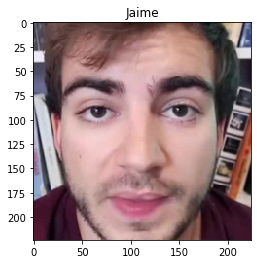

In [5]:
inputs, _ = next(iter(A_dataset))

imshow(inputs, title='Jaime')

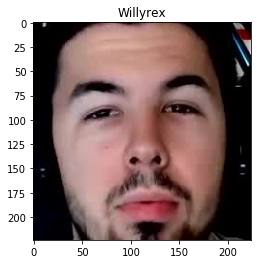

In [6]:
inputs, _ = next(iter(B_dataset))

imshow(inputs, title='Willyrex')

In [7]:
modelA = Autoencoder().to(device)
modelB = Autoencoder().to(device)

In [8]:
criterion = nn.MSELoss()

optimizerA = optim.Adam(modelA.parameters(), lr=0.001)
optimizerB = optim.Adam(modelB.parameters(), lr=0.001)

In [9]:
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [10]:
epochs = 5

lossA_plot = []
lossB_plot = []

save_path = "./checkpoints/"

if not os.path.exists(save_path):
    os.makedirs(save_path)
    
iteration = 0
for epoch in range(epochs):
    start = time.time()
    
    for (A_imgs, _), (B_imgs, _) in zip(A_loader, B_loader):
        
        A = Variable(A_imgs).to(device)
        B = Variable(B_imgs).to(device)

        optimizerA.zero_grad()
        optimizerB.zero_grad()

        outputsA = model(A)
        outputsB = model(B)

        lossA = criterion(outputsA, A)
        lossB = criterion(outputsB, B)

        lossA.backward()
        lossB.backward()
        
        optimizerA.step()
        optimizerB.step()
        
        lossA_plot.append(lossA.item())
        lossB_plot.append(lossB.item())
        
        #if iteration % 500 == 0:
        #    imshow(make_grid(model(jaime_imgs).detach().cpu()[0]), title=str(iteration))

        iteration +=1
            
        
    finish = time.time()
        
    print(f"Epoch {epoch+1}/{epochs} ({round((epoch+1)/epochs * 100, 2)}%) | LossA: {lossA.item()}, LossB: {lossB.item()} | The loop took {round(finish-start, 2)} seconds.")
    
    if (finish-start)*(epochs-epoch) > 60:
        print(f"Estimated time left {round((finish-start)*(epochs-epoch)/60, 2)} minutes.")
    else:
        print(f"Estimated time left {round((finish-start)*(epochs-epoch), 2)} seconds.")
        
    torch.save(modelA.state_dict(), f"{save_path}epoch-{epoch+1}(A).pth")
    torch.save(modelB.state_dict(), f"{save_path}epoch-{epoch+1}(B).pth")    

NameError: name 'model' is not defined

In [ ]:
plt.plot(loss_graph)

In [ ]:
display(imshow(make_grid(model(jaime_imgs).detach().cpu()[0]), title=str(iteration)))